In [1]:
import os
from sys import path
dir_actual = os.getcwd()
path.insert(0, 'C:/Users/guill/OneDrive/Documentos/Tesis/Proyect')

import myfuncions.randomize_f as myrand
import myfuncions.core_shell_f as cs
import myfuncions.tools_f as tools
import subprocess as sbp
import myfuncions.graphs_f as gf
from myfuncions.lammpin_f import wlammpin
import time
import PDF.runner as pdf

coords = cs.cubeShell(14,2.775,'fcc')
atpos, eleList = cs.atpos_eleList_maker(coords,'Pt')
atpos, eleList = tools.spherical_cut(atpos, eleList, 25)
atpos, eleList, mode = myrand.cambiar_elementos_prob(atpos,{'Pt':0.28, 'Pd':0.45, 'Co':0.27})
tools.show_percent(atpos, eleList)

Corta esfericamente al atpos
Cambia elementos prob a atpos
atomos totales : 4321
Pt : 27.100208285119184 %, 1171
Co : 27.725063642675305 %, 1198
Pd : 45.17472807220551 %, 1952


In [5]:
temps = [300, 500, 700]

for i in temps:
    name = f'p{i}.xyz'
    tools.show_percent(atpos, eleList)

    try: 
        os.remove(name)
        os.remove(name[:-4]+'.ini')
        os.remove(name[:-4]+'_d.xyz')
        os.remove(name[:-4]+'_d2.xyz')
        os.remove(name[:-4]+'_d2.txt')
    except: pass

    tools.wXYZ(atpos, name)
    wlammpin(atpos,eleList,name)


    tf = i

    input = f"""
    # 2NN EAM potential in LAMMPS

     units		metal
     atom_style	atomic
     boundary	f f f

     read_data	{name[:-4]}.ini
     pair_style	meam
     pair_coeff	* * ..\\..\\LAMMPS\\library-PtPdCo.meam Pt Pd Co ..\\..\\LAMMPS\\PtPdCo.pot Pt Pd Co
  
     neighbor	0.5 bin
     neigh_modify	every 1 delay 0 check yes once no
     velocity	all create 0.00 13478 rot yes mom yes dist gaussian
     timestep	0.005

     fix            1 all nve
     fix            2 all temp/rescale 10 0.00 0.00 1.0 1
     thermo         100
     thermo_style   custom step temp atoms pe ke etotal
     thermo_modify  lost ignore
     run 600

     unfix 2
     fix         3 all temp/berendsen 0.0 {tf} 0.1
     thermo		100
     run		{tf*20}

     unfix 3
     timestep   0.001
     thermo		100
     fix		4 all langevin {tf} {tf} 0.5 87654
     dump       4 all xyz 1 dump_temp.xyz
     undump     4
     run        1
     dump       4 all xyz 599 {name[:-4]}_d.xyz
     run		3000
     """
    with open('input.in','w') as archivo:
        archivo.write(input)

    os.system('start powershell -Command lmp -in input.in; Start-Sleep -s 10; exit')
    #os.system('start powershell -Command lmp -in input.in')
    time.sleep(tf*2)
    print(f'MD for {i} done!!')

    datpos, deleList = tools.leer_xyz(f'{name[:-4]}_d.xyz')
    datpos, deleList = tools.cambiar_etiquetas_xyz(datpos, deleList, {1: 'Pt', 2: 'Pd', 3:'Co'})
    tools.show_percent(datpos, ['Pt','Pd','Co'])
    tools.wXYZ(datpos,f'{name[:-4]}_d2.xyz')

    
    pdf.run_pdf(f'{name[:-4]}_d2.xyz', dir_actual, 2600,0.02)



atomos totales : 4321
Pd : 44.87387178893775 %, 1939
Pt : 28.141633881046054 %, 1216
Co : 26.9844943300162 %, 1166
p300.ini
MD for 300 done!!
Cambia etiquetas a "atpos"
jala
atomos totales : 4321
Pt : 28.141633881046054 %, 1216
Pd : 44.87387178893775 %, 1939
Co : 26.9844943300162 %, 1166
c:\Users\guill\OneDrive\Documentos\Tesis\Proyect\05_31_2024_probes_w_temp_vac\probes_t

  0.191799998      -7.46771002      -22.8237991              46   215524.000    
  -3.53781009      -3.66454005      -22.8957996              46   215524.000    
  0.162980005      -3.83848000      -22.7245007              78   215524.000    
        4321  atomos      9333360  pares 
 Rango de distancias    2.30831027     -   48.7490921    
 Distancias promedio    24.9635906    
 Factor de normalizacion    458619.219    

atomos totales : 4321
Pd : 44.87387178893775 %, 1939
Pt : 28.141633881046054 %, 1216
Co : 26.9844943300162 %, 1166
p500.ini
MD for 500 done!!
Cambia etiquetas a "atpos"
jala
atomos totales : 4321
P

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
M = pd.DataFrame()

temps = [300, 500, 700]

df_exp = pd.read_csv('../../04_26_2024_comparision_variables/Post-PtPdCo-PDF.csv', sep = '\s+', header=None, names=['r','G(r)'])
df_exp = df_exp.replace('--',np.nan).dropna()
rest_df_exp = df_exp["G(r)"].iloc[1::2].astype(float)
rest_df_exp = rest_df_exp.reset_index(drop=True)
rest_df_exp.index += 1
M['exp'] = rest_df_exp

dx = 0.02

#M.index = M0['#r(A)']
M300 = pd.read_csv('p300_d2.txt', sep='\s+')
M500 = pd.read_csv('p500_d2.txt', sep='\s+')
M700 = pd.read_csv('p700_d2.txt', sep='\s+')
M['300 K'] = M300['G(r)']
M['500 K'] = M500['G(r)']
M['700 K'] = M700['G(r)']
M.index = (M.index + 1)*dx

for i in temps:
    a = M[M[f'{i} K']== max(M[f'{i} K'])].index[0]
    b = 0.29 #### Al parecer este es el originario de todo lo que yo estaba haciendo
    c = b/(float(M[f'{i} K'][a]))
    M[f'{i} K'] *= c
    rest = M['exp'] - M[f'{i} K']
    error = np.sum(rest**2)
    error_p = np.sqrt(error)*100/50
    print(f'Para {i} K el error es {error},y el error porcentual es {error_p}')




fig = px.line(M, template='seaborn', title='Pair Distribution Functions of 9 Models',
    width=1000, height=600)
fig.update_layout(
    font_family="serif",
    title_font_family="serif")
fig.update_xaxes(title_text='G(r)')
fig.update_yaxes(title_text='r [A]')
fig.show()

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\guill\AppData\Local\Temp\ipykernel_22220\2801995013.py:8: SyntaxWarning: invalid escape sequence '\s'
  df_exp = pd.read_csv('../../04_26_2024_comparision_variables/Post-PtPdCo-PDF.csv', sep = '\s+', header=None, names=['r','G(r)'])
C:\Users\guill\AppData\Local\Temp\ipykernel_22220\2801995013.py:18: SyntaxWarning: invalid escape sequence '\s'
  M300 = pd.read_csv('p300_d2.txt', sep='\s+')
C:\Users\guill\AppData\Local\Temp\ipykernel_22220\2801995013.py:19: SyntaxWarning: invalid escape sequence '\s'
  M500 = pd.read_csv('p500_d2.txt', sep='\s+')
C:\Users\guill\AppData\Local\Temp\

Para 300 K el error es 2.9540104575573367,y el error porcentual es 3.4374469930792166
Para 500 K el error es 2.0566965615316346,y el error porcentual es 2.8682374807757007
Para 700 K el error es 1.5855927666975063,y el error porcentual es 2.5184064538493436


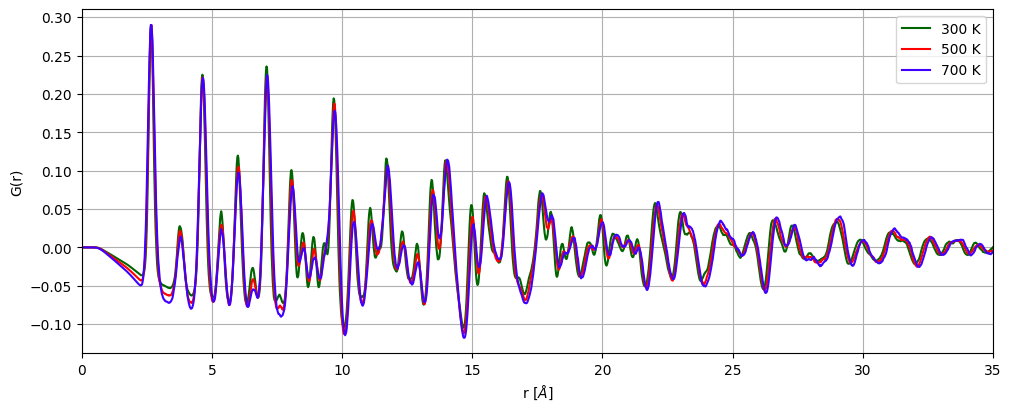

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,4), layout='constrained')

#ax.plot(M.index,M['exp'], label='Experimental', color='black')
ax.plot(M.index, M['300 K'], label='300 K', color='darkgreen')
ax.plot(M.index, M['500 K'], label='500 K', color='red')
ax.plot(M.index, M['700 K'], label='700 K', color = '#3F00FF')

ax.set_xlabel('r [$\\AA$]')
ax.set_xlim([0,35])
ax.set_ylabel('G(r)')

ax.legend(loc='upper right')
ax.grid()
plt.rc('font', size='12')
plt.rcParams['font.family']='serif'
plt.show()

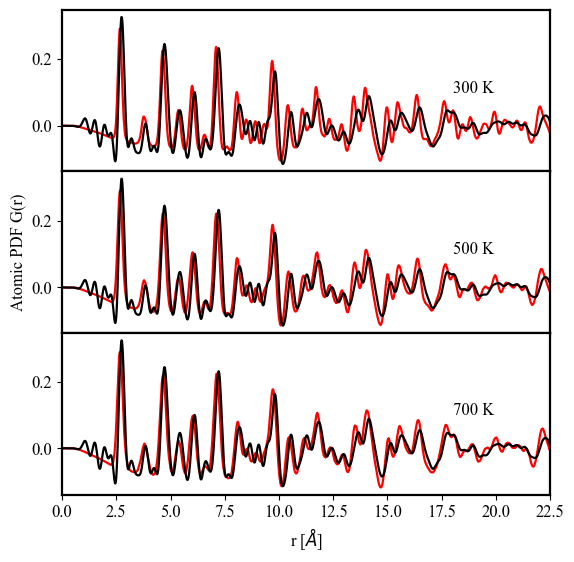

In [5]:
ancho_cm = 16
alto_cm = 16
ancho_pulg = ancho_cm / 2.54
alto_pulg = alto_cm / 2.54

fig, ax =plt.subplots(3,1, sharex=True, figsize=(ancho_pulg, alto_pulg))
fig.subplots_adjust(hspace=0)

ax[0].plot(M.index, M['300 K'], label = '300 K', color = 'red', lw=1.6)
ax[0].plot(M.index, M['exp'], color = 'black', lw=1.6)

ax[1].plot(M.index, M['500 K'], label = '500 K', color = 'red', lw=1.6)
ax[1].plot(M.index, M['exp'], color = 'black', lw=1.6)

ax[2].plot(M.index, M['700 K'], label = '700 K', color = 'red', lw=1.6)
ax[2].plot(M.index, M['exp'], color = 'black', lw=1.6)

ax[2].set_xlabel('r [$\\AA$]')
ax[1].set_ylabel('Atomic PDF G(r)')

for i in range(3):
    ax[i].set_xlim([0,22.5])
    #ax[i].label_outer()
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set(linewidth = 1.6)


ax[0].text(*[18,0.1], '300 K', rotation_mode='anchor')
ax[1].text(*[18,0.1], '500 K', rotation_mode='anchor')
ax[2].text(*[18,0.1], '700 K', rotation_mode='anchor')




plt.rc('font', size=12)

#fpath = Path(mpl.get_data_path(), "C:/Users/guill/Downloads/Fira_Sans/FiraSans-Medium.ttf")

plt.rcParams['font.serif'] = ['Times New Roman']
plt.show()